# Importing Libraries

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
import torchvision
from PIL import Image
import numpy as np
import torch.nn.functional as F
import shutil
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp, XGradCAM

## Hyperparameters

In [2]:
# Setting seed value
seed_value= 255
torch.manual_seed(seed_value)
np.random.seed(seed_value)

path_to_data= "./Main_data"

IMG_SIZE = 256
targets= {0: 'OK', 1:'not_OK'}

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001
num_epochs = 100
batch_size = 128
# Early stopping parameters
patience = 10
counter = 0

# Preparing the data

## Loading the data

In [3]:
init_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True)])

init_dataset = torchvision.datasets.ImageFolder(root=path_to_data, 
                                                transform=init_transform
                                                )
print(f"The total number of images is : {len(init_dataset)} images (from : {path_to_data})")

The total number of images is : 21 images (from : ./Main_data)


## Data Augmentation

In [4]:
# Transformations for images with defects
defect_image_transforms1 = transforms.Compose([
                                              transforms.RandomVerticalFlip(p=0.6)
                                              ])

# Transformations for normal images
defect_image_transforms2 = transforms.Compose([ 
                                              transforms.RandomHorizontalFlip(p=0.4) 
                                              ])

transformed_data1, transformed_data2 = [], []
for image, label in init_dataset:    
    if label == 1: 
        # images with defects
        transformed_image1 = defect_image_transforms1(image)
        transformed_data1.append((transformed_image1, label))
    else: 
        # normal images
        transformed_image2 = defect_image_transforms2(image)
        transformed_data2.append((transformed_image2, label))
        # or pass
        
# Merge the original images with the transformed images
final_dataset = init_dataset + transformed_data1 + transformed_data2

data, labels = [], []
for image, label in final_dataset:
    data.append(image)
    labels.append(label)

print(f'After data augmentation, the total number is : {len(labels)} images, and the number of nio images is : {sum(labels)}')

After data augmentation, the total number is : 42 images, and the number of nio images is : 18


## Splitting the data into train, validation and test sets

In [5]:
generator = torch.Generator().manual_seed(seed_value)

train_val_dataset, test_dataset = torch.utils.data.random_split(final_dataset, [0.8, 0.2], generator=generator)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [0.8, 0.2], generator=generator)

tensor_data = torch.stack([train_val_dataset[i][0] for i in range(len(train_val_dataset))])
train_val_mean = np.mean(tensor_data.numpy())
train_val_std = np.std(tensor_data.numpy())
print(f"The number of images for train/val/test is : {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)} images")

# Data Preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Grayscale(),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.9, hue=0.1),
        transforms.Normalize(train_val_mean, train_val_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Grayscale(),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.9, hue=0.1),
        transforms.Normalize(train_val_mean, train_val_std)
    ]),
    'pred': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.Grayscale(),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.9, hue=0.1),
        transforms.Normalize(mean=train_val_mean, std=train_val_std)
    ])
}

The number of images for train/val/test is : 28/6/8 images


## Creating dataloaders and applying transformations

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        # Load the image and label from your data
        image, label = self.data[index]
        
        # Apply the transformation (if specified)
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.data)  
    
train_data = MyDataset(train_dataset, transform=data_transforms['train'])
val_data = MyDataset(val_dataset, transform=data_transforms['train'])
test_data = MyDataset(test_dataset, transform=data_transforms['test'])

train_loader= DataLoader(train_data, batch_size=batch_size, shuffle= True, generator=generator, pin_memory = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, generator=generator, pin_memory = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=generator, pin_memory = True)

## Visualize some samples

/Users/youssef/miniconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


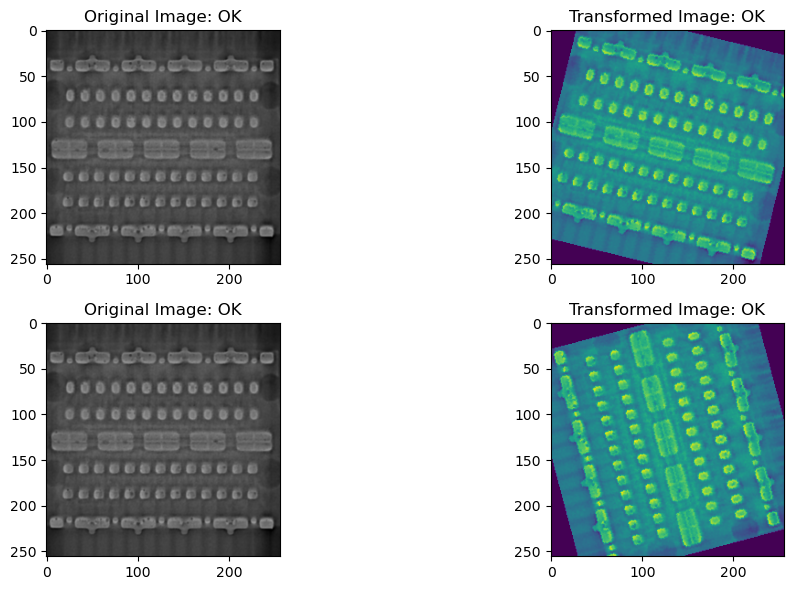

In [7]:
# Sample from the training set
plt.figure(figsize= (12,6))

img1, label1 = train_dataset[1]

plt.subplot(2, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title("Original Image: {}".format(targets[label1]))

img1 = data_transforms['train'](img1)
plt.subplot(2, 2, 2)
plt.imshow(img1.permute(1, 2, 0))
plt.title("Transformed Image: {}".format(targets[label1]))

# Sample from the test set
img2, label2 = test_dataset[2]

plt.subplot(2, 2, 3)
plt.imshow(img2.permute(1, 2, 0))
plt.title("Original Image: {}".format(targets[label2]))

img2 = data_transforms['test'](img2)
plt.subplot(2, 2, 4)
plt.imshow(img2.permute(1, 2, 0))
plt.title('Transformed Image: {}'.format(targets[label2]))
plt.tight_layout()

plt.show();

# Preparing the training

## Creating the model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Add dropout here
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Add dropout here
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Add dropout here
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)  # Add dropout here
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Classifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Classifier, self).__init__()
        self.autoencoder = Autoencoder(dropout_rate=dropout_rate)
        with torch.no_grad():
            sample_input = next(iter(train_loader))[0]
            encoded_output = self.autoencoder.encoder(sample_input.to(device))
            flattened_size = encoded_output.view(encoded_output.size(0), -1).size(1)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(flattened_size, 2)

    def forward(self, x):
        encoded_output = self.autoencoder.encoder(x.to(device))
        encoded_output = self.dropout(encoded_output)  # Apply dropout after the encoder in the classifier
        encoded_output = encoded_output.view(encoded_output.size(0), -1)
        output = self.fc(encoded_output)
        return output

In [10]:
class EarlyStopping:
    def __init__(self, patience= 5, verbose=False, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")
        else:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)

In [11]:
# Create Model
model = Classifier(dropout_rate=0.5).to(device)

# Loss function
class_weights = torch.FloatTensor([sum(labels)/len(labels), 1 - sum(labels)/len(labels)])
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
early_stopping = EarlyStopping(patience=patience, verbose=True)

## Training and Validation Loops

In [ ]:
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [], []
val_recall_list = []

for epoch in range(num_epochs):
    # Train Loop
    train_loss, train_correct, train_total = 0, 0, 0
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss / len(train_loader))

    # Validation Loop
    val_loss, val_correct, val_total, val_tp, val_fn = 0, 0, 0, 0, 0

    y_true = np.array([])
    y_pred = np.array([])

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true = np.concatenate((y_true, labels.numpy()))
            y_pred = np.concatenate((y_pred, predicted.numpy()))
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_tp += ((predicted == 1) & (labels == 1)).sum().item()
            val_fn += ((predicted == 0) & (labels == 1)).sum().item()
        val_accuracy = val_correct / val_total
        val_recall = val_tp / (val_tp + val_fn)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss / len(val_loader))
        val_recall_list.append(val_recall)

    # Early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        break

    print('Epoch [{}/{}], Training Accuracy: {:.2f}%, Training Loss: {:.4f}, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
            .format(epoch + 1, num_epochs, train_accuracy * 100, train_loss, val_accuracy * 100, val_loss))

## Plot training and validation loss/accuracy

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

x = range(1, len(train_loss_list) + 1)
axes[0].plot(x, train_loss_list, label='Train Loss')
axes[0].plot(x, val_loss_list, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(x, train_accuracy_list, label='Train Accuracy')
axes[1].plot(x, val_accuracy_list, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## Validation performance  (Confusion Matrix, Recall, F1 score)

In [ ]:
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['OK', 'not_OK'])
recall= recall_score( y_true, y_pred, average='binary')
f1= f1_score( y_true, y_pred, average='binary')

print('\n', 'Confusion Matrix:\n', cm)
print('\n', 'Classification Report:\n', report)
print('\n', "Recall is equal to: ", round(recall,3))
print('\n', "f1_score is equal to: ", round(f1,3))

# Save the final model checkpoint

In [15]:
torch.save(model.state_dict(), 'model.pt')

## Load the model checkpoint

In [16]:
model = Classifier().to(device)
model.load_state_dict(torch.load('model.pt'))
model.eval();

/Users/youssef/miniconda3/envs/PyTorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Testing the model on test data

In [ ]:
model.eval()
y_true = []
y_pred = []
test_loss = 0
test_correct = 0
test_total = 0
test_tp = 0  # true positives
test_fn = 0  # false negatives

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_tp += ((predicted == 1) & (labels == 1)).sum().item()
        test_fn += ((predicted == 0) & (labels == 1)).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

test_accuracy = test_correct / test_total
test_recall = test_tp / (test_tp + test_fn)
test_f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)
# recall= recall_score(y_true, y_pred)

print('Test Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Recall: {:.2f}%, Test f1: {:.2f}%'
          .format(test_accuracy * 100, test_loss / len(test_loader), test_recall * 100, test_f1 * 100))
print('\n', 'Confusion Matrix:')
print('\n', cm)
print('\n', 'Classification Report:')
print('\n', report)
# print("Test Reacall is equal to: ", recall)

# Prediction to new Images

## For a Folder of images

In [ ]:
Ok_dir = './Main_data/Prediction/Predictedimages/OK'
not_Ok_dir =  './Main_data/Prediction/Predictedimages/not_OK'
os.makedirs(Ok_dir, exist_ok=True)
os.makedirs(not_Ok_dir, exist_ok=True)

# Folder containing the images to predict
folder_path= "./Main_data/Prediction/Data"

# Iterate over each image in the folder
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = data_transforms['pred'](image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Perform the prediction
    with torch.no_grad():
        output = model(image)

    # Get the predicted class label
    _, predicted_idx = torch.max(output, 1)

    predicted_label = "OK" if predicted_idx.item() == 0 else "not_OK"

    if predicted_label == 'OK':
        shutil.copy2(image_path, Ok_dir)
    else:
        shutil.copy2(image_path, not_Ok_dir)
    print(f"Image: {filename}, Predicted label: {predicted_label}")


## For a specific image

In [ ]:
# Load and preprocess the new image
image_path= './Main_data/io_53.jpg'

image = Image.open(image_path).convert('RGB')
image = data_transforms['pred'](image)
image = image.unsqueeze(0)  # Add batch dimension

# Perform the prediction
with torch.no_grad():
    output = model(image)

# Get the predicted class label
_, predicted_idx = torch.max(output, 1)
predicted_label = "OK" if predicted_idx.item() == 0 else "not_OK"

print("Predicted label:", predicted_label)

# Classifying the defect images on different groups

In [ ]:
from skimage import io
from sklearn.cluster import KMeans

image_directory = "./Main_data/not_OK"

num_clusters = 3

# Get the list of image files in the directory
image_files = [file for file in os.listdir(image_directory) if file.endswith((".jpg", ".jpeg", ".png"))]

images = []
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    image = io.imread(image_path)
    images.append(image)

images = np.array(images)

# Reshape the image array if necessary (e.g., if your images are grayscale)
# images = images.reshape(images.shape[0], -1)

# Flatten the image array if necessary (e.g., if your images are color)
images = images.reshape(images.shape[0], -1)

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(images)

# Retrieve the cluster labels assigned to each image
cluster_labels = kmeans.labels_

image_clusters = {}

# Assign images to their respective clusters
for i, label in enumerate(cluster_labels):
    image_path = os.path.join(image_directory, image_files[i])
    if label not in image_clusters:
        image_clusters[label] = set()
    image_clusters[label].add(image_path)

# Print the image clusters and labels
for cluster, image_set in image_clusters.items():
    print(f"Cluster {cluster}:")
    for image_path in image_set:
        print(image_path)
    print()


## Visualize feature maps

In [18]:
# Load a specific image
# Edit the path to the image you want to load
image_path= './Main_data/niO/niO_1.jpg'

sample_image = Image.open(image_path).convert('RGB')
sample_image = data_transforms['pred'](sample_image)

# Use dataloader
# sample_image = next(iter(train_loader))[0][0]
# print(sample_image.shape)
print(sample_image.shape)


torch.Size([1, 256, 256])


### Visualization of ALL Feature Maps

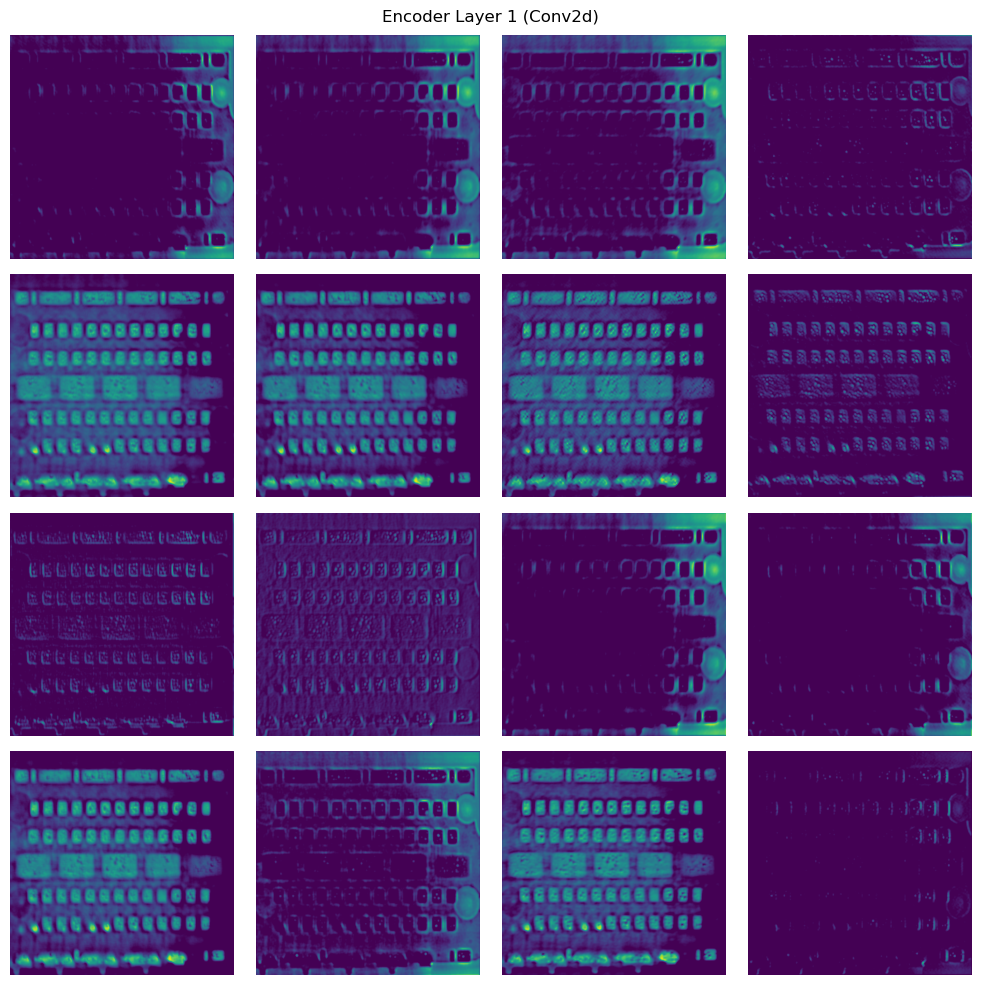

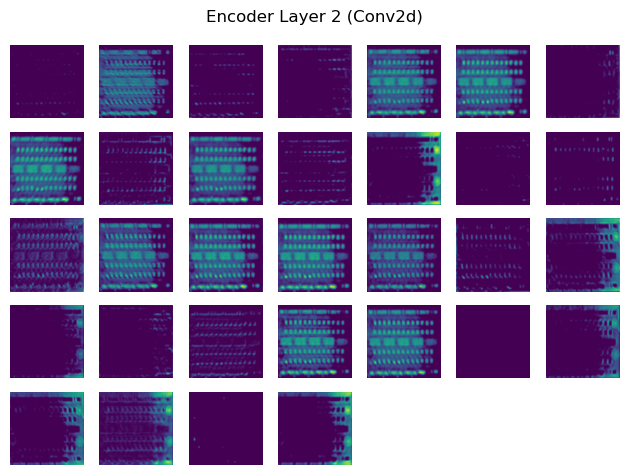

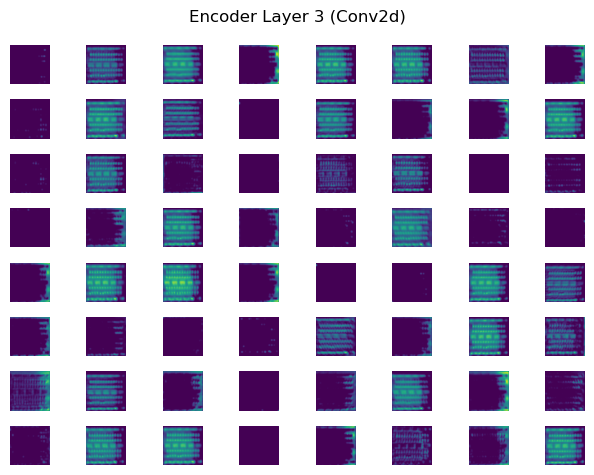

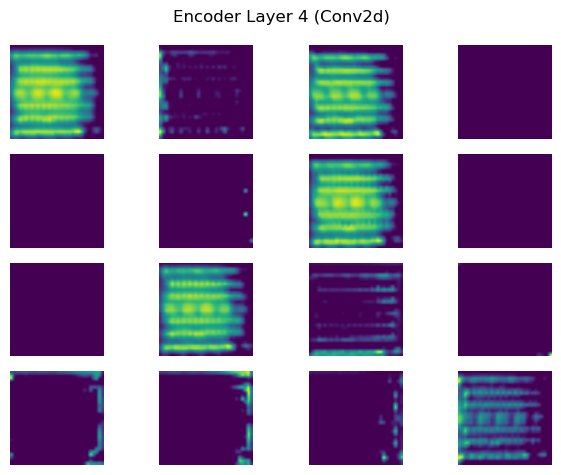

In [19]:
def visualize_all_feature_maps(model, image, onlyLastConv=False):
    # Set the model to evaluation mode
    model.eval()
    # Initialize a list to store feature maps
    feature_maps = []
    # Initialize the input tensor for passing through the model
    x = image
    # Loop through the encoder layers of the model
    for layer in model.autoencoder.encoder:
        # Pass the input through the layer
        x = layer(x)

        # Check if the layer is a convolutional layer
        if isinstance(layer, nn.Conv2d):
            # Append the layer name and its output to the feature_maps list
            feature_maps.append((layer._get_name(), x))

    # If onlyLastConv is True, keep only the last convolutional layer's output in feature_maps
    if onlyLastConv: feature_maps = feature_maps[-1:]

    # print(f"Number of layers: {len(feature_maps)}")
    
    plt.figure(figsize=(10, 10))
    # Loop through the collected feature maps
    for i, (name, feature_map) in enumerate(feature_maps):
        # Get the number of individual features in the feature map
        num_features = feature_map.size(0)
        rows = int(num_features**0.5)
        cols = (num_features + rows - 1) // rows

        # Loop through individual feature maps
        for j in range(num_features):
            plt.subplot(rows, cols, j + 1)
            feature = feature_map[j].cpu()

            # Resize the feature map if its shape doesn't match the input image shape
            if (feature.shape != image.shape[1:]):
                feature = F.interpolate(feature.unsqueeze(0).unsqueeze(0),
                                        size=image.shape[1:],
                                        mode='bilinear',
                                        align_corners=False
                                        ).squeeze()
            plt.axis('off')

            # Display the feature map using a specified colormap and interpolation method
            plt.imshow(feature.detach().numpy(), cmap='viridis', interpolation="bicubic")

        # If not onlyLastConv, add a title indicating the encoder layer
        if not onlyLastConv:
             plt.suptitle(f"Encoder Layer {i+1} ({name})")
        plt.tight_layout()
        plt.show()
        
# Call the function with the specified arguments
visualize_all_feature_maps(model, sample_image, onlyLastConv=False)

### Gradient-based methods

In [20]:
def visualize_SmoothGradCampp(model, image, onlyLastConv=False):
    # Set the model to evaluation mode
    model.eval()
    # Create a new figure for visualization
    plt.figure(figsize=(10, 5))

    # Collect all Conv2d layers from the encoder
    layers = [layer for layer in model.autoencoder.encoder if isinstance(layer, nn.Conv2d)]
    # If onlyLastConv is True, keep only the last Conv2d layer
    if onlyLastConv: 
        layers = [layers[-1]]

    # Loop through the selected layers
    for i, layer in enumerate(layers):
        # Instantiate the SmoothGradCAMpp module for the current layer
        cam = SmoothGradCAMpp(
            model.autoencoder.encoder,
            target_layer=layer,
            num_samples=50,
            std=train_val_std
        )
        # Pass the image through the encoder to get scores
        scores = model.autoencoder.encoder(image.unsqueeze(0))

        # Generate the activation map using SmoothGradCAM++
        activation_map = cam(class_idx=0, scores=scores)[0]
        
        # Resize the activation map if its shape doesn't match the image shape
        if (activation_map.shape != image.shape):
            activation_map = F.interpolate(activation_map.unsqueeze(0).unsqueeze(0),
                                    size=image.shape[1:],
                                    mode='bilinear',
                                    align_corners=True
                                    ).squeeze(0)

        # Display the activation map using a specified colormap and interpolation method
        plt.imshow(activation_map[0], cmap='viridis', interpolation="bicubic")
        # If not onlyLastConv, add a title indicating the layer
        if not onlyLastConv:
            plt.suptitle(f"Layer {i+1} ({layer._get_name()})")

        # Adjust the layout, add grid lines, and display the plot
        plt.tight_layout()
        plt.grid(True)
        plt.savefig(f'heatmap{i+1}.png', dpi=fig.dpi)
        plt.show()

def visualize_XGradCAM(model, image, onlyLastConv=False):
    # Set the model to evaluation mode
    model.eval()
    # Create a new figure for visualization
    plt.figure(figsize=(10, 5))
    # Collect all Conv2d layers from the encoder
    layers = [layer for layer in model.autoencoder.encoder if isinstance(layer, nn.Conv2d)]
    
    # If onlyLastConv is True, keep only the last Conv2d layer
    if onlyLastConv:
        layers = [layers[-1]]

    # Loop through the selected layers
    for i, layer in enumerate(layers):
        # Instantiate the XGradCAM module for the current layer
        cam = XGradCAM(model.autoencoder.encoder, target_layer=layer)

        # Pass the image through the encoder to get scores
        scores = model.autoencoder.encoder(image.unsqueeze(0))
        
        # Generate the activation map using XGradCAM
        activation_map = cam(class_idx=0, scores=scores)[0]
        
        # Resize the activation map if its shape doesn't match the image shape
        if (activation_map.shape != image.shape):
            activation_map = F.interpolate(activation_map.unsqueeze(0).unsqueeze(0),
                                    size=image.shape[1:],
                                    mode='bilinear',
                                    align_corners=True
                                    ).squeeze(0)

        plt.imshow(activation_map[0], cmap='viridis',  interpolation="bicubic")
        
        # If not onlyLastConv, add a title indicating the layer
        if not onlyLastConv:
            plt.suptitle(f"Layer {i+1} ({layer._get_name()})")

        # Adjust the layout, add grid lines, and display the plot
        plt.tight_layout()
        plt.grid(True)

        plt.savefig(f'heatmap{i+1}.png', dpi=fig.dpi)
        plt.show()


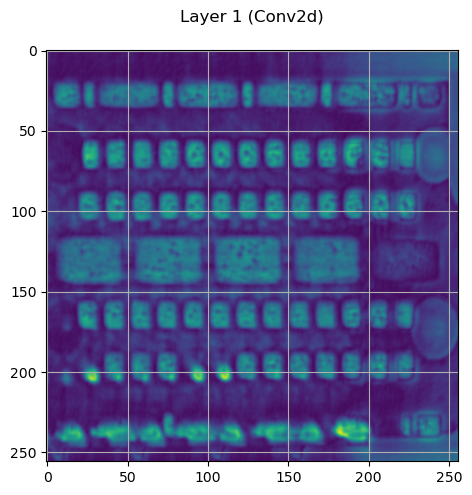

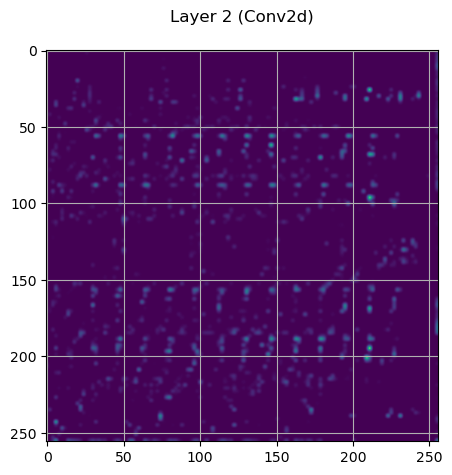

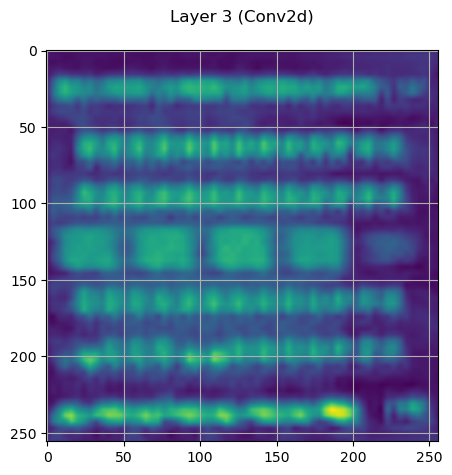

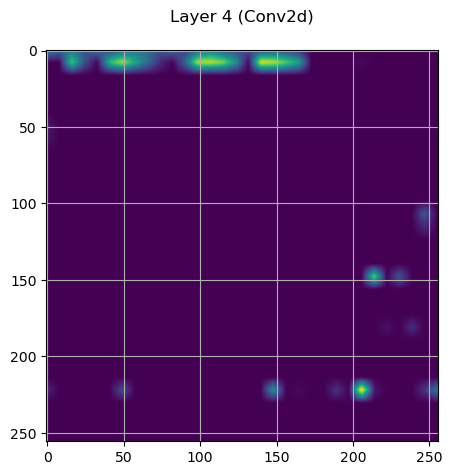

In [23]:
# For every conv layer
visualize_SmoothGradCampp(model, sample_image, onlyLastConv=False)

# For the last layer
# visualize_SmoothGradCampp(model, sample_image, onlyLastConv=True)

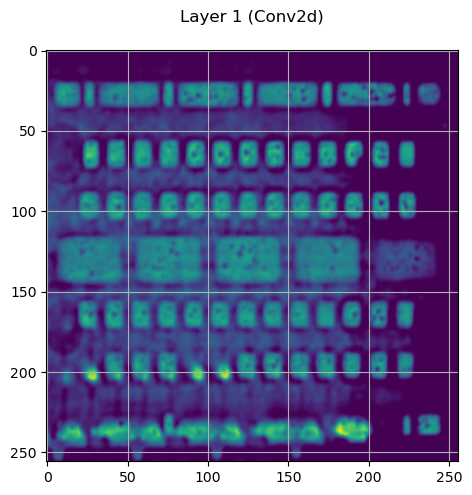

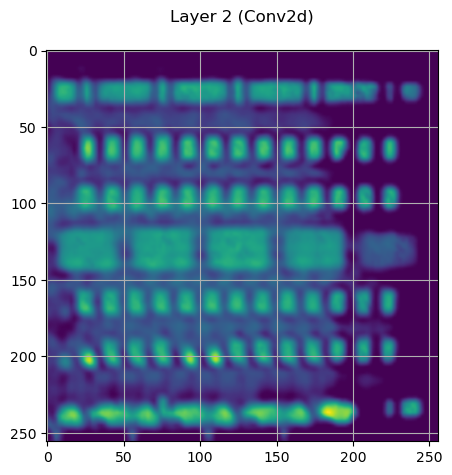

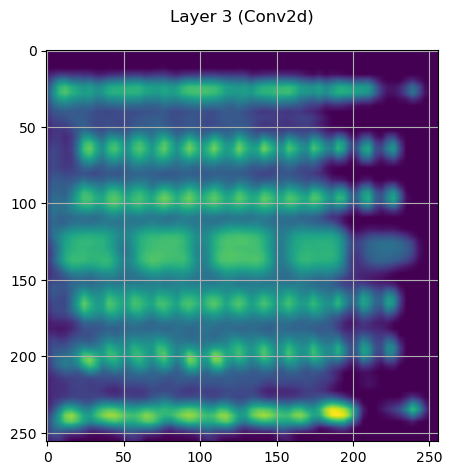

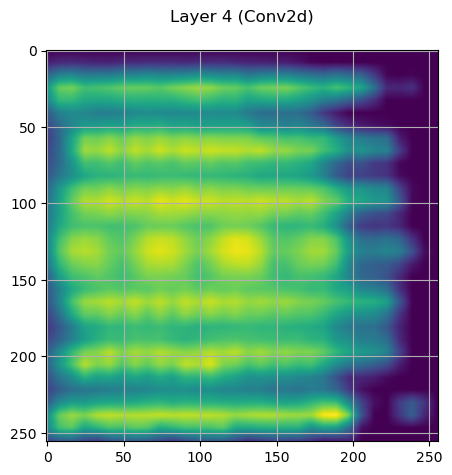

In [21]:
visualize_XGradCAM(model, sample_image, onlyLastConv=False)